In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager
import seaborn as sns
import numpy as np  # 导入 numpy
from scipy.stats import kruskal
import glob
import bbi
from scipy.signal import savgol_filter  # 导入Savitzky-Golay滤波器


# font_manager.fontManager.ttflist.append(font_manager.FontProperties(fname='/cluster/home/futing/miniforge-pypy3/envs/HiC/fonts/Arial.ttf'))
# arial_font = font_manager.FontProperties(fname='Arial.ttf')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial'] 
plt.rcParams['pdf.fonttype'] = 42

In [2]:
font_files = font_manager.findSystemFonts(fontpaths='/cluster/home/futing/miniforge-pypy3/envs/HiC/fonts/')
 
for file in font_files:
    font_manager.fontManager.addfont(file)

#### ChIP 信号的覆盖率	
* 来源于pre.sh

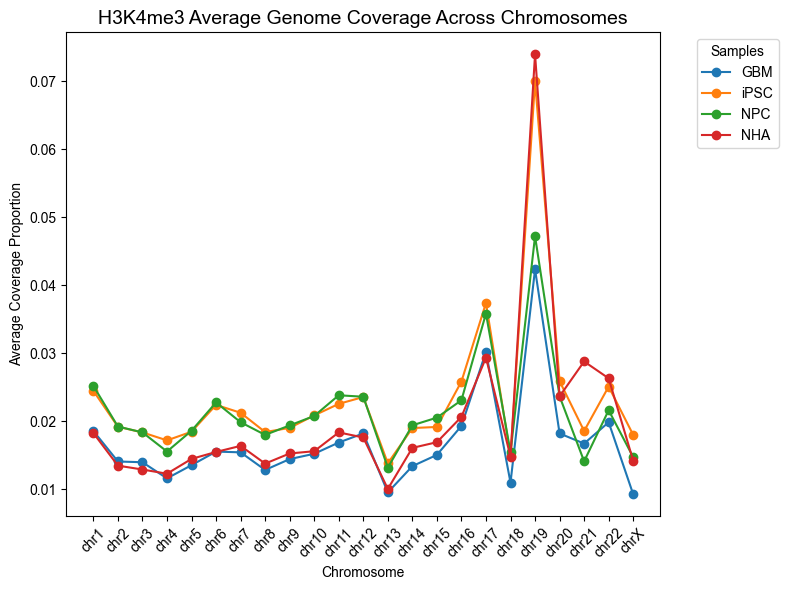

In [5]:
# 获取所有 *_chip_coverage.txt 文件路径
file_paths = glob.glob('/cluster/home/futing/Project/GBM/HiC/hubgene/new/H3K4me3/addID/*_chip_coverage.txt')

plt.figure(figsize=(8, 6))

# 遍历每个文件并绘制线图
for file_path in file_paths:
    # 读取文件
    coverage = pd.read_csv(
        file_path,
        sep='\t',
        header=None,
        names=['chrom', 'start', 'end', 'col4', 'col5', 'col6', 'coverage']
    )

    # 按染色体计算平均覆盖度
    chrom_avg_coverage = coverage.groupby('chrom')['coverage'].mean().reset_index()

    # 按染色体顺序排序（保证线图顺序一致）
    chrom_avg_coverage['chrom'] = pd.Categorical(
        chrom_avg_coverage['chrom'], 
        categories=[f'chr{i}' for i in range(1, 23)] + ['chrX'], 
        ordered=True
    )
    chrom_avg_coverage = chrom_avg_coverage.sort_values('chrom')

    # 只保留 chr1 到 chr22 和 chrX 的数据
    chrom_avg_coverage = chrom_avg_coverage[chrom_avg_coverage['chrom'].isin([f'chr{i}' for i in range(1, 23)] + ['chrX'])]

    # 获取文件名（用于图例显示）
    sample_name = file_path.split('/')[-1].replace('_chip_coverage.txt', '')

    # 绘制线图
    plt.plot(
        chrom_avg_coverage['chrom'], 
        chrom_avg_coverage['coverage'], 
        marker='o', 
        linestyle='-', 
        label=sample_name
    )

# 设置图例和轴标签
plt.xlabel('Chromosome')
plt.ylabel('Average Coverage Proportion')
plt.title('H3K4me3 Average Genome Coverage Across Chromosomes',fontsize=14)
plt.legend(title='Samples', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45,fontsize=10)  # 调整X轴染色体号显示角度
plt.tight_layout()
plt.savefig("/cluster/home/futing/Project/GBM/HiC/hubgene/new/H3K4me3/cvg_H3K4me3.pdf", format='pdf')



FileNotFoundError: [Errno 2] No such file or directory: '/cluster/home/futing/Project/GBM/HiC/hubgene/new/chip/addID/avgprofile_hub_summary.bed'

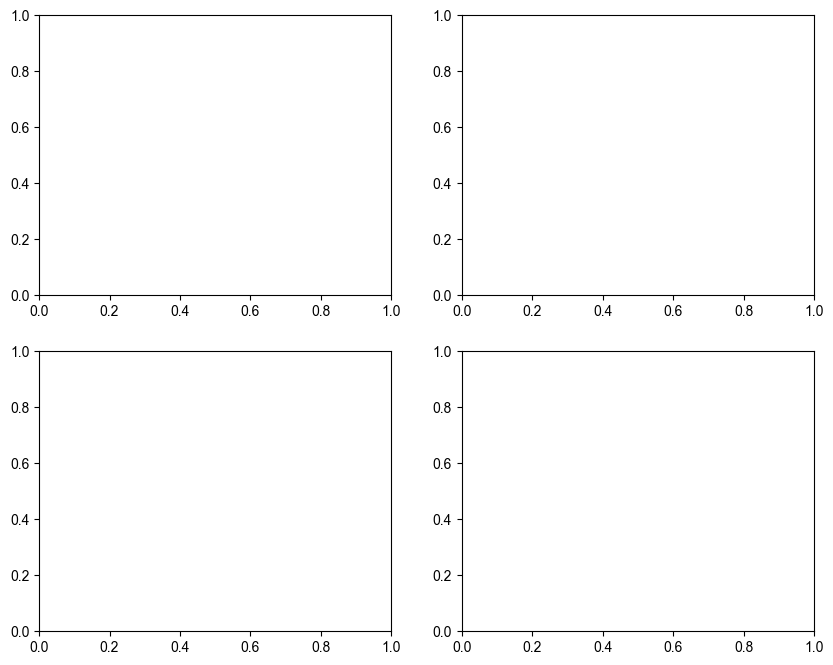

In [9]:
# 需要每种基因的位置
# 文件路径模板
ctcf_peak_files = {
	'GBM': '/cluster/home/futing/Project/GBM/HiC/hubgene/new/H3K4me3/addID/GBM.merge_BS_detail.bw',
	'NHA': '/cluster/home/futing/Project/GBM/HiC/hubgene/new/H3K4me3/addID/NHA.merge_BS_detail.bw',
	'NPC': '/cluster/home/futing/Project/GBM/HiC/hubgene/new/H3K4me3/addID/NPC.merge_BS_detail.bw',
	'iPSC': '/cluster/home/futing/Project/GBM/HiC/hubgene/new/H3K4me3/addID/iPSC.merge_BS_detail.bw'
}

# 创建一个2x2的子图
fig, axes = plt.subplots(2, 2, figsize=[10, 8])

# 设置染色体过滤
valid_chromosomes = [f'chr{i}' for i in range(1, 23)] + ['chrX']

# 循环处理每个数据集
for idx, (cell, ctcf_peak_file) in enumerate(ctcf_peak_files.items()):
	# 读取BED文件
	file_path = f'/cluster/home/futing/Project/GBM/HiC/hubgene/new/chip/addID/avgprofile_hub_summary.bed'
	CTCF_boundaries_conserve = pd.read_csv(file_path, sep='\t', header=0)

	# 提取需要的列
	flank = 3000
	nbins = 1000
	boundaries = CTCF_boundaries_conserve.iloc[:, 0:3].drop_duplicates()
	boundaries.columns = ['chrom', 'start', 'end']

	# 提取 hub/non-hub 列
	hub_status = CTCF_boundaries_conserve[f'{cell}_hub']  # 根据cell变量选择正确的列

	# 过滤染色体
	boundaries = boundaries[boundaries['chrom'].isin(valid_chromosomes)]

	# 提取hub和non-hub基因的边界
	# hub_boundaries = boundaries[hub_status == 'HiC hub']
	# non_hub_boundaries = boundaries[hub_status == 'HiC non-hub']
	# nonHIC_boundaries = boundaries[hub_status == 'non-HiC']
	hub_boundaries = boundaries.loc[hub_status.index[hub_status == 'HiC hub']]
	non_hub_boundaries = boundaries.loc[hub_status.index[hub_status == 'HiC non-hub']]
	nonHIC_boundaries = boundaries.loc[hub_status.index[hub_status == 'non-HiC']]


	# 获取CTCF峰值数据（stackup）
	stackup_hub = bbi.stackup(
		ctcf_peak_file,
		hub_boundaries.chrom,
		hub_boundaries.start - flank,
		hub_boundaries.start + flank,
		bins=nbins,
	)

	stackup_non_hub = bbi.stackup(
		ctcf_peak_file,
		non_hub_boundaries.chrom,
		non_hub_boundaries.start - flank,
		non_hub_boundaries.start + flank,
		bins=nbins,
	)

	stackup_nonHIC = bbi.stackup(
		ctcf_peak_file,
		nonHIC_boundaries.chrom,
		nonHIC_boundaries.start - flank,
		nonHIC_boundaries.start + flank,
		bins=nbins,
	)

	# 对数据进行平滑处理，使用Savitzky-Golay滤波器
	stackup_hub_smoothed = savgol_filter(np.nanmean(stackup_hub, axis=0), window_length=101, polyorder=2)
	stackup_non_hub_smoothed = savgol_filter(np.nanmean(stackup_non_hub, axis=0), window_length=101, polyorder=2)
	stackup_nonHIC_smoothed = savgol_filter(np.nanmean(stackup_nonHIC, axis=0), window_length=101, polyorder=2)

	# 选择当前子图位置
	ax = axes[idx // 2, idx % 2]  # 计算当前的子图位置

	# 对所有hub基因TSS位置的CTCF信号取平均
	ax.plot(stackup_hub_smoothed, label=f'HiC hub Genes ({len(hub_boundaries)})', color='red')  # 红色表示hub基因
	ax.plot(stackup_non_hub_smoothed, label=f'HiC non-hub Genes ({len(non_hub_boundaries)})', color='blue')  # 蓝色表示non-hub基因
	ax.plot(stackup_nonHIC_smoothed, label=f'non-HiC Genes ({len(nonHIC_boundaries)})', color='grey')

	# 设置图形的标签和标题
	xticks_positions = np.linspace(0, nbins, 5, dtype=int)  # 选择5个显示的位置
	xticklabels_values = (xticks_positions - nbins // 2) * flank * 2 / nbins / 1000  # 计算对应的标签值（单位为kb）

	ax.set(
		xticks=xticks_positions,  # 只显示这些位置
		xticklabels=xticklabels_values,  # 设置对应的标签
		xlabel='Distance from TSS, kb',
		ylabel='H3K4me3 ChIP-Seq',
	)

	# 设置X轴字体大小
	ax.tick_params(axis='x', labelsize=10)

	# 设置标题为当前的cell类型
	ax.set_title(cell, fontsize=14, fontweight='bold')

	# 添加图例
	ax.legend()

# 调整布局，防止重叠
plt.tight_layout()

# 如果需要保存图形，可以取消注释以下行
plt.savefig(f'/cluster/home/futing/Project/GBM/HiC/hubgene/new/H3K4me3/H3K4me3_avg_profile_hub.pdf', format='pdf', dpi=500, bbox_inches='tight', pad_inches=0.5)
plt.show()